In [1]:
import torch
import torch.nn as nn
from Model import model, modelArguments
import time
import re
import math
import triton


In [2]:
CUDA_LAUCH_BLOCKING = 1

TORCH_USE_CUDA_DSA = True



In [3]:
torch.set_float32_matmul_precision('medium')

In [4]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


In [5]:
fmodel = model(modelArguments)
fmodel = fmodel.to('cuda')



In [6]:
# fmodel(a, a)

In [7]:
for name, para in fmodel.named_parameters():
    print(name)

shared_emb.shared_weight
enc_layers.0.norm1.weight
enc_layers.0.norm1.bias
enc_layers.0.norm2.weight
enc_layers.0.norm2.bias
enc_layers.0.attention.q_linear.weight
enc_layers.0.attention.k_linear.weight
enc_layers.0.attention.v_linear.weight
enc_layers.0.attention.out_linear.weight
enc_layers.0.feedforward.fc1.weight
enc_layers.0.feedforward.fc2.weight
enc_layers.1.norm1.weight
enc_layers.1.norm1.bias
enc_layers.1.norm2.weight
enc_layers.1.norm2.bias
enc_layers.1.attention.q_linear.weight
enc_layers.1.attention.k_linear.weight
enc_layers.1.attention.v_linear.weight
enc_layers.1.attention.out_linear.weight
enc_layers.1.feedforward.fc1.weight
enc_layers.1.feedforward.fc2.weight
enc_layers.2.norm1.weight
enc_layers.2.norm1.bias
enc_layers.2.norm2.weight
enc_layers.2.norm2.bias
enc_layers.2.attention.q_linear.weight
enc_layers.2.attention.k_linear.weight
enc_layers.2.attention.v_linear.weight
enc_layers.2.attention.out_linear.weight
enc_layers.2.feedforward.fc1.weight
enc_layers.2.feedforw

In [8]:
# mmodel = MathM(modelArguments).to('cuda')
def initialize_weights(m):
    if isinstance(m, torch.nn.Linear):
        nn.init.normal_(m.weight, std=0.1)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, torch.nn.Embedding):
        nn.init.normal_(m.weight, std=0.1)

# Apply the function to the model
fmodel.apply(initialize_weights)


state_dict = torch.load('./checkpoints/model_weightsBPE6.pth')
new_state_dict = {k.replace('_orig_mod.', ''): v for k, v in state_dict.items()}
fmodel.load_state_dict(new_state_dict, strict=False)

/tmp/ipykernel_47853/3620063255.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('./checkpoints/model_weightsBPE6.pth')


<All keys matched successfully>

In [9]:
fmodel = fmodel.to('cuda')
# fmodel = torch.compile(fmodel)
# fmodel = fmodel

In [10]:
count_parameters(fmodel)

48256000

In [ ]:
from datasets import load_dataset
from torch.utils.data import DataLoader, IterableDataset
from transformers import PreTrainedTokenizerFast
import pickle
import os
import json

# dataset = load_dataset("damerajee/english-to-hindi-l", split="train", streaming=False)
# dataset = load_dataset("TIGER-Lab/MATH-plus", split="train", streaming=False)
dataset = load_dataset("HuggingFaceFW/fineweb", name="CC-MAIN-2024-10", split="train", streaming=True)


/home/frosthead/.conda/envs/DL/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
tokenizer = PreTrainedTokenizerFast(tokenizer_file="large_tokenizer.json")


In [ ]:
def tokenize(text, second = False):
    ids = tokenizer.encode(text, add_special_tokens=True)
    ids1 = [1] + ids + [2] 
    ids1 = torch.tensor(ids1, dtype=torch.int16)
    
    # Pad or truncate the sequence to tholtae max_seq_length
    if ids1.size(0) < modelArguments.max_seq_len:
        padding_length = modelArguments.max_seq_len - ids1.size(0)
        ids1 = torch.cat([ids1, torch.zeros(padding_length, dtype=torch.int16)])
        
    elif ids1.size(0) >= modelArguments.max_seq_len:
        ids1 = ids1[:modelArguments.max_seq_len]
        ids1[-1] = 2
    return ids1

In [ ]:
class TokenizedIterableDataset(IterableDataset):
    def __init__(self, dataset, args,state_file='dataset_state.pkl'):
        self.dataset = dataset
        self.state_file = state_file
        self.buffer = ""
        self.current_index = 0
    #   -  self.load_state()
        self.args = args
    #     # self.norm = torch.nn.BatchNorm1d(args.enforce_features, affine=False)
    #     # self.norm2 = torch.nn.BatchNorm1d(args.enforce_features, affine=False)
    #     self.embd = nn.Embedding(32768, 512)


    def __iter__(self):
        index = 0
        buffer = None
        for example in self.dataset:
            # print("len of exp :",self.dataset)
            if index < self.current_index:
                index += 1
                continue

            # instruction = example['instruction']
            # output = example['output']

            # out = instruction + " " + output
            # out = tokenize(out)
            # yield out
            # self.current_index = index
            # index += 1


            text = example['text']
            lines = text.split('.')
            # print("# lines :",len(lines))
            for line in lines:
                # if (buffer != None):
                #     yield buffer
                self.buffer += line 
                if len(self.buffer)  >= modelArguments.max_seq_len*5:
                    tokenized_input = tokenize(self.buffer)

                    
                    yield tokenized_input
                    self.buffer = line 


            self.current_index = index
            # self.save_state()
            index += 1

        # Tokenize the remaining buffer if it's not empty
        if len(self.buffer) > 0:
            tokenized_input = tokenize(self.buffer)
            if tokenized_input is not None:
                yield tokenized_input




    def save_state(self):
        state = {'buffer': self.buffer, 'current_index': self.current_index}
        with open(self.state_file, 'wb') as f:
            pickle.dump(state, f)

    def load_state(self):
        if os.path.exists(self.state_file):
            with open(self.state_file, 'rb') as f:
                state = pickle.load(f)
                self.buffer = state.get('buffer', "")
                self.current_index = state.get('current_index', 0)

    def reset(self):
        self.buffer = ""
        self.current_index = 0
        # self.save_state()

def collate_fn(batch): # Maximum number of attempts to create a valid batch
    
        # for attempt in range(max_attempts):
        inputs = torch.stack([item for item in batch])

        return inputs
# Create an instance of the IterableDataset
train_dataset = TokenizedIterableDataset(dataset,modelArguments)

# Create a DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=modelArguments.max_batch_size, collate_fn=collate_fn)


In [ ]:
var = 0
for k, a in enumerate(train_dataloader):
    print(a.shape)
    break
    

# print(var)



torch.Size([8, 256])


In [ ]:
def id_to_token(x):
    s = ''
    for i in x[0]:
        # j = torch.argmax(i)
        s += tokenizer.decode(i)

    return s

def id_to_token_M(x):
    s = ''
    for i in x[0]:
        j = torch.argmax(i)
        s += tokenizer.decode(j)

    return s

In [ ]:
class TransformerLRScheduler(torch.optim.lr_scheduler.LambdaLR):
    def __init__(self, optimizer, d_model, warmup_steps):
        self.d_model = d_model
        self.warmup_steps = warmup_steps
        super().__init__(optimizer, self.lr_lambda)

    def lr_lambda(self, step):
        step = max(step, 1)  # To avoid division by zero
        return (self.d_model ** -0.5) * min(step ** -0.5, step * self.warmup_steps ** -1.5)


In [ ]:
# history = []
history = torch.load('checkpoints/history1.pth')
rloss = 0

/tmp/ipykernel_46065/2764386670.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  history = torch.load('checkpoints/history1.pth')


In [ ]:
loss_fn = nn.CrossEntropyLoss(ignore_index=0)
loss_fn2 = nn.MSELoss()
loss_fn3 = nn.MSELoss()
loss_fn4 = nn.MSELoss()
optimizer = torch.optim.AdamW(fmodel.parameters(), betas=(0.9, 0.99), lr = 1e-4)
optimizer.load_state_dict(torch.load('checkpoints/optimizer1.pth'))
optimizer.zero_grad()
torch.cuda.empty_cache()
# schedular = TransformerLRScheduler(optimizer, 512, 500)

/tmp/ipykernel_46065/763023964.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  optimizer.load_state_dict(torch.load('checkpoints/optimizer1.pth'))


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_loss_with_trend(loss_array, window_size=25):
    """
    Plots the loss function with an additional line to show the trend.

    Args:
    loss_array (list or np.array): Array of loss values.
    window_size (int): The window size for calculating the moving average trend line.
    """
    # Convert loss_array to a numpy array if it's not already
    loss_array = np.array(loss_array)

    # Calculate the moving average for the trend line
    trend_line = np.convolve(loss_array, np.ones(window_size)/window_size, mode='valid')
    trend = (trend_line[0]-trend_line[-1])/trend_line.size
    trend2 = (trend_line[-1]-trend_line[-window_size-1])/window_size if len(trend_line) > window_size else 0
    

    # Plot the loss function
    print("overall :",trend)
    print("last window :",trend2)

    plt.figure(figsize=(10, 6))
    plt.plot(loss_array, label='Loss', color='blue', alpha=0.6)
    plt.plot(range(window_size - 1, len(loss_array)), trend_line, label='Trend', color='red', linestyle='--', linewidth=2)

    # Adding labels and title
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.title('Loss Function with Trend Line')
    plt.legend()
    plt.grid(True)
    plt.savefig('current_loss.jpg')
    plt.show()

In [ ]:
optimizer.zero_grad()
torch.cuda.empty_cache()
from IPython.display import clear_output
rloss = 0


In [ ]:
TORCHDYNAMO_VERBOSE=1

In [ ]:
open = False
for epoch in range(4000):
    # data_loader = tqdm(train_dataloader, unit="batch")
    global_step = 0
    train_dataset.reset()
    sloss = 0
    train_dataloader = DataLoader(train_dataset, batch_size=modelArguments.max_batch_size, collate_fn=collate_fn)
    for batch_idx, a in enumerate(train_dataloader):

        a = a.to(torch.long).to('cuda')

        max_no_tokens = 2**6
        # accumulation_steps2 = 1
        accumulation_steps = max_no_tokens//(modelArguments.max_batch_size)

        # print(accumulation_steps)
        

        t0 = time.time()
        out = fmodel(a)
        loss = loss_fn(out[:, :modelArguments.max_seq_len-1, :].contiguous().view(-1, out.size(-1)), a[:, 1:modelArguments.max_seq_len].contiguous().view(-1)) #+ loss_fn3(se, d)
        # loss = loss_fn3(se,d)
        loss = loss / accumulation_steps





        rloss += loss.item()
        # scaler.scale(loss).backward()
        loss.backward()



        # if(batch_idx+1) % (2**10) and len(history) > 50 == 0:
        #     print("Images Saved")
        #     plot_loss_with_trend(history[1:], window_size=25)

            
        # if loss_fn4(se2,e) >= 10000:
        #     print("out: ", id_to_token(a),"\n")
        #     print("Output shape:", e[0], "\n")
        #     print("Target shape:", se2[0], "\n")
        #     print(loss.item(), loss_fn4(se2,e),loss_fn(out[:, :modelArguments.max_seq_len-1, :].contiguous().view(-1, out.size(-1)), c[:, 1:modelArguments.max_seq_len].contiguous().view(-1)) , loss_fn3(se, d), "\n")
        
        if (batch_idx+1) % ((max_no_tokens / modelArguments.max_batch_size)*8) == 0 or math.isnan(loss):

            clear_output()
            print("-"*6,f" Loss: {rloss}", "-"*6,"\n")
            print("out: ", id_to_token(a),"\n")

            print("out: ", id_to_token_M(out),"\n")


            print('\n')

            
        
        if (batch_idx+1) % accumulation_steps == 0:
            # scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(fmodel.parameters(), max_norm=1)
            # scaler.step(optimizer)
            optimizer.step()
            # schedular.step()
            # scaler.update()
            global_step += 1
            optimizer.zero_grad()

            history.append(rloss)
            
            torch.cuda.synchronize()
            t1 = time.time()

            dt = (t1-t0)*1000 
        # if (batch_idx % 10 == 0):       
            # print(f"-----Steps : {global_step}, Loss: {rloss:8f}, LR: {schedular.get_last_lr()}, #tokens : {max_no_tokens} ,timeT : {dt}ms ----- ")
            print(f"-----Steps : {global_step}, BatchIDX : {batch_idx}, Loss: {rloss:8f}, #tokens : {max_no_tokens} ,timeT : {dt}ms ----- ")
    
            rloss = 0
        torch.cuda.empty_cache()

    print(f"Epoch {epoch+1} completed, {batch_idx}")   


# Close the writer after training
# writer.close()

# Remove hooks after training is done
# for hook in hooks:

#     hook.remove()


RuntimeError: The size of tensor a (256) must match the size of tensor b (8) at non-singleton dimension 1

In [ ]:
se[0], e[0]

(tensor([[4.6746e+00, 3.5948e+00, 3.0292e+00, 2.2992e+00, 1.9814e+00, 1.6484e+00,
          1.1950e+00, 1.4389e+00, 1.0268e+00, 9.2477e-01, 8.2266e-01, 7.3887e-01,
          3.5669e-01, 6.2320e-01, 5.9211e-01, 3.3420e-01, 8.9923e-02, 9.2636e-02,
          4.3759e-01, 6.2237e-02, 6.7157e-01, 3.7226e-01, 1.7359e-01, 5.0016e-01,
          1.0000e+01, 1.3141e-01, 3.0200e-01, 2.4225e-01, 6.4371e-02, 3.6889e-01,
          1.9881e-01, 6.5745e-01, 1.1970e-01, 1.0317e-01, 3.0235e-01, 4.6172e-01,
          3.3271e-01, 4.9603e-01, 1.1059e-01, 1.1381e-01, 1.8963e-01, 1.3152e-01,
          2.2227e-01, 1.2889e-01, 1.2541e-01, 4.6300e-01, 2.9229e-01, 1.3701e-01,
          6.2920e-02, 1.1754e-01, 0.0000e+00, 2.2004e-01, 1.8300e-05, 1.1929e-01,
          3.9607e-01, 1.5108e-01, 3.2215e-01, 3.9339e-01, 2.4935e-01, 2.3376e-02,
          1.9834e-01, 9.5308e-02, 3.1176e-01, 1.7991e-01]], device='cuda:0',
        grad_fn=<SelectBackward0>),
 tensor([[10.0000,  3.4000, 10.0000,  3.4000,  0.4000,  0.4000,  3.

In [ ]:
torch.save(fmodel.state_dict(), 'checkpoints/model_weightsBPE6.pth')
torch.save(optimizer.state_dict(), 'checkpoints/optimizer1.pth')
torch.save(history, 'checkpoints/history1.pth')             

overall : 0.0002765892512642791
last window : -0.00013679976910353276


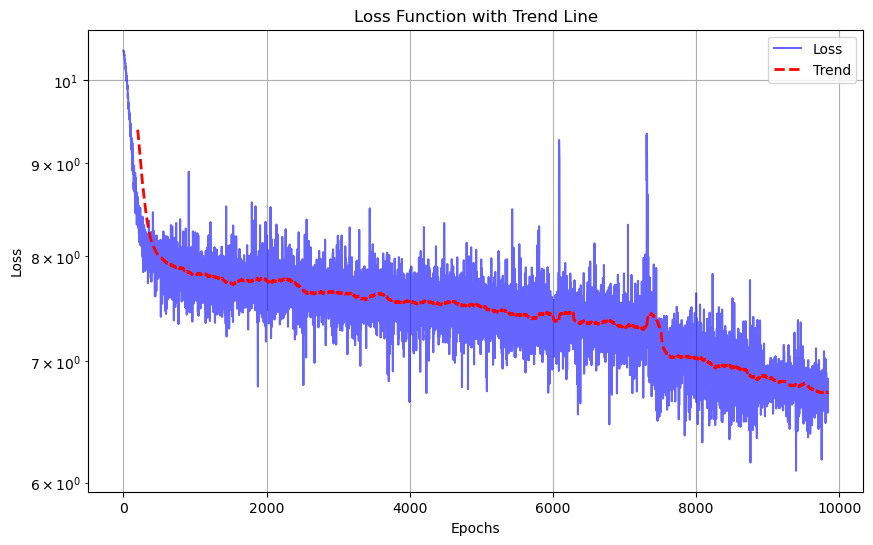

In [ ]:
# plt.plot(history[3920:])
# plt.yscale('log')
# plt.show()
# history = torch.load('checkpoints/history1.pth')
plot_loss_with_trend(history[8:], window_size=200)